In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/My Drive/Internship Files/Velozity/"

In [ ]:
!pip install matplotlib==3.1.3

---

<br>

## **1. Loading Data/Packages**

In [ ]:
!pip install wfdb
!pip install matplotlib==3.1.3

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wfdb

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

---

<br>

## **2. Two Class Test CNN**

In [ ]:
records = np.loadtxt(DATA_PATH + "mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

In [ ]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

In [ ]:
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0    

In [ ]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [ ]:
print(records[0], type(records[0]))

100 <class 'numpy.int64'>


In [ ]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []

for subject in records:
    record = wfdb.rdrecord(DATA_PATH + str(subject))
    annotation = wfdb.rdann(DATA_PATH + str(subject), 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [ ]:
subject_map = pd.DataFrame(subject_map)
subject_map.head()

,subject,percentage,num_seq,start,end
0,100,0.015018,2264,0,2264
1,101,0.002691,1858,2264,4122
2,102,0.954566,2179,4122,6301
3,103,0.000962,2078,6301,8379
4,104,0.926610,2221,8379,10600


In [ ]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

In [ ]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

In [ ]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [ ]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [ ]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(filters=8, kernel_size=4, strides=1, input_shape=(sequence_size, n_features), 
           padding="same", activation="relu"),
    Flatten(),
    Dropout(0.5),
    Dense(1, activation="sigmoid", name="output",)
])

In [ ]:
optimizer = Adam(lr=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2160, 8)           40        
                                                                 
 flatten (Flatten)           (None, 17280)             0         
                                                                 
 dropout (Dropout)           (None, 17280)             0         
                                                                 
 output (Dense)              (None, 1)                 17281     
                                                                 
Total params: 17,321
Trainable params: 17,321
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
648/648 [==============================] - 67s 100ms/step - loss: 0.2376 - accuracy: 0.9151 - val_loss: 0.5922 - val_accuracy: 0.8163
Epoch 2/15
648/648 [==============================] - 57s 88ms/step - loss: 0.1821 - accuracy: 0.9394 - val_loss: 0.6007 - val_accuracy: 0.8245
Epoch 3/15
648/648 [==============================] - 56s 86ms/step - loss: 0.1703 - accuracy: 0.9444 - val_loss: 0.6080 - val_accuracy: 0.8120
Epoch 4/15
648/648 [==============================] - 56s 86ms/step - loss: 0.1610 - accuracy: 0.9475 - val_loss: 0.6135 - val_accuracy: 0.8222
Epoch 5/15
648/648 [==============================] - 55s 86ms/step - loss: 0.1551 - accuracy: 0.9492 - val_loss: 0.6249 - val_accuracy: 0.8123
Epoch 6/15
648/648 [==============================] - 56s 86ms/step - loss: 0.1512 - accuracy: 0.9518 - val_loss: 0.6478 - val_accuracy: 0.8189
Epoch 7/15
648/648 [==============================] - 56s 86ms/step - loss: 0.1487 - accuracy: 0.9526 - val_loss: 0.6424 - val_accuracy

In [ ]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 8s 10ms/step - loss: 0.7705 - accuracy: 0.8130


[0.7704641222953796, 0.8129783868789673]

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

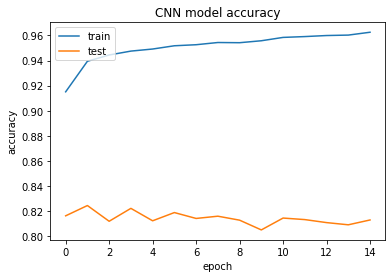

In [ ]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

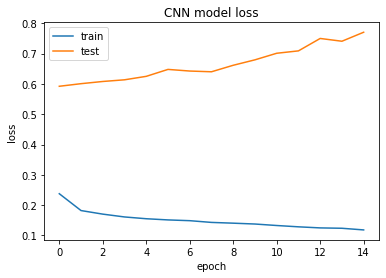

In [ ]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---

<br>

## **3. Multi Class Test CNN**

### **A. EDA**

In [ ]:
from sklearn.utils import resample
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
train_df = pd.read_csv(DATA_PATH + 'mitbih_train.csv',header=None)
test_df = pd.read_csv(DATA_PATH + 'mitbih_test.csv',header=None)

train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,0.030992,0.028926,0.035124,0.026860,0.039256,0.035124,0.043388,0.047521,0.053719,0.053719,0.070248,0.072314,0.084711,0.097107,0.121901,0.132231,0.169421,0.196281,0.214876,0.235537,0.254132,0.264463,0.285124,0.272727,0.266529,0.239669,0.214876,0.173554,0.157025,0.123967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,0.304029,0.336996,0.377289,0.391941,0.439560,0.446886,0.457875,0.479853,0.512821,0.534799,0.586081,0.586081,0.604396,0.633700,0.615385,0.582418,0.564103,0.520147,0.490842,0.490842,0.468864,0.454212,0.450549,0.465201,0.450549,0.432234,0.424908,0.410256,0.391941,0.369963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,0.106195,0.141593,0.128319,0.150442,0.132743,0.150442,0.132743,0.150442,0.123894,0.163717,0.137168,0.141593,0.132743,0.150442,0.128319,0.146018,0.119469,0.123894,0.101770,0.092920,0.070796,0.079646,0.066372,0.070796,0.079646,0.092920,0.088496,0.084071,0.079646,0.088496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,0.102083,0.122917,0.150000,0.168750,0.172917,0.170833,0.168750,0.164583,0.156250,0.152083,0.147917,0.147917,0.145833,0.145833,0.141667,0.141667,0.147917,0.158333,0.168750,0.179167,0.191667,0.206250,0.220833,0.239583,0.258333,0.275000,0.287500,0.308333,0.320833,0.331250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,0.080537,0.104027,0.093960,0.117450,0.097315,0.134228,0.124161,0.161074,0.171141,0.194631,0.204698,0.261745,0.275168,0.332215,0.345638,0.395973,0.406040,0.456376,0.446309,0.446309,0.399329,0.369128,0.308725,0.295302,0.265101,0.271812,0.258389,0.268456,0.261745,0.281879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
len(train_df)

87554

In [29]:
def plot_class_balance(train_df, title):
  train_df[187] = train_df[187].astype(int)
  class_count = train_df[187].value_counts()
  colors = {"Normal":'red', "Paced":'green', "Premature ventricular contraction":"blue", "Atrial premature":"skyblue", "Fusion of ventricular and normal": "orange"} 
  labels = ["Normal", "Paced", "Premature ventricular contraction", "Atrial premature", "Fusion of ventricular and normal"]

  sns.set_palette(sns.color_palette(colors.values()))

  fig, ax = plt.subplots(figsize=(14,8))
  sns.barplot(y = class_count, x=['N (0)','Q (4)','V (2)','S (1)','F (3)'])

  for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'{h:0.2f}'
    ax.annotate(s=h, xy=xy, ha='center', weight='bold')

  handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
  plt.legend(handles, labels)
  plt.xlabel("Classes", fontsize=12)
  plt.ylabel("Number of examples in each class", fontsize=12)
  plt.title(title, fontsize=14)

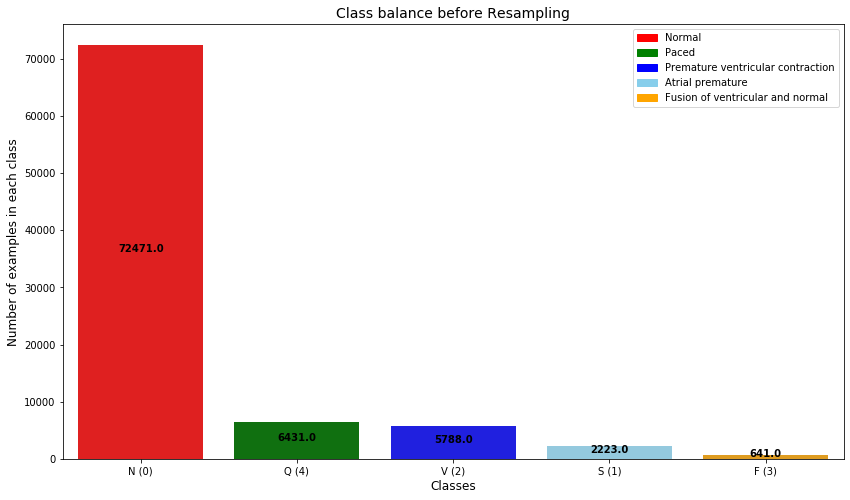

In [30]:
plot_class_balance(train_df, "Class balance before Resampling")

In [31]:
df_1 = train_df[train_df[187]==1]
df_2 = train_df[train_df[187]==2]
df_3 = train_df[train_df[187]==3]
df_4 = train_df[train_df[187]==4]
df_0 = (train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample = resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample = resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample = resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample = resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df = pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

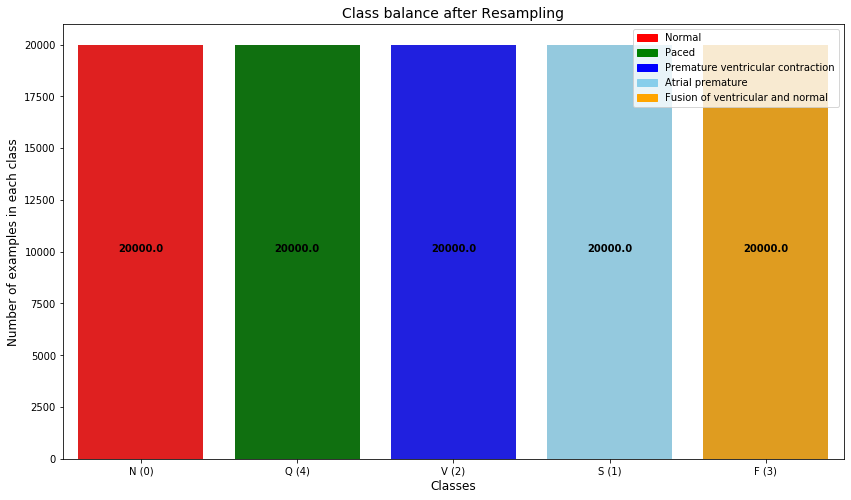

In [32]:
plot_class_balance(train_df, "Class balance after Resampling")

In [33]:
c = train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
49351,0.981443,0.898969,0.360825,0.000000,0.142268,0.169072,0.187629,0.187629,0.200000,0.195876,0.200000,0.206186,0.204124,0.206186,0.200000,0.218557,0.216495,0.230928,0.228866,0.253608,0.243299,0.255670,0.261856,0.284536,0.286598,0.325773,0.338144,0.377320,0.410309,0.435052,0.465979,0.513402,0.521649,0.554639,0.550515,0.556701,0.536082,0.529897,0.490722,0.451546,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
74202,0.960784,0.830065,0.205882,0.000000,0.241830,0.274510,0.290850,0.307190,0.295752,0.295752,0.303922,0.299020,0.295752,0.299020,0.303922,0.308824,0.300654,0.310458,0.323529,0.318627,0.325163,0.333333,0.339869,0.343137,0.339869,0.349673,0.359477,0.357843,0.352941,0.361111,0.367647,0.362745,0.364379,0.367647,0.385621,0.395425,0.388889,0.379085,0.372549,0.351307,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
76207,1.000000,0.961818,0.749091,0.490909,0.327273,0.212727,0.167273,0.118182,0.116364,0.118182,0.100000,0.072727,0.080000,0.061818,0.032727,0.014545,0.021818,0.012727,0.021818,0.027273,0.025455,0.000000,0.021818,0.012727,0.005455,0.021818,0.032727,0.030909,0.038182,0.034545,0.050909,0.080000,0.096364,0.100000,0.121818,0.149091,0.149091,0.163636,0.180000,0.190909,...,0.292727,0.283636,0.312727,0.303636,0.303636,0.325455,0.341818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80872,1.000000,0.757009,0.412773,0.088785,0.045171,0.113707,0.087227,0.045171,0.042056,0.038941,0.031153,0.023364,0.012461,0.000000,0.010903,0.007788,0.023364,0.031153,0.042056,0.062305,0.082555,0.116822,0.160436,0.182243,0.218069,0.263240,0.300623,0.333333,0.350467,0.370717,0.392523,0.384735,0.392523,0.395639,0.378505,0.366044,0.348910,0.328660,0.320872,0.289720,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
82369,0.673813,0.566616,0.460949,0.336907,0.203675,0.122511,0.068913,0.042879,0.058193,0.082695,0.156202,0.261868,0.310873,0.330781,0.373660,0.424196,0.473201,0.526799,0.558959,0.594181,0.612557,0.624809,0.633997,0.644717,0.650842,0.650842,0.647779,0.660031,0.675345,0.687596,0.699847,0.712098,0.730475,0.747320,0.774885,0.797856,0.817764,0.839204,0.856049,0.880551,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


Text(0.5, 1.0, 'Paced')

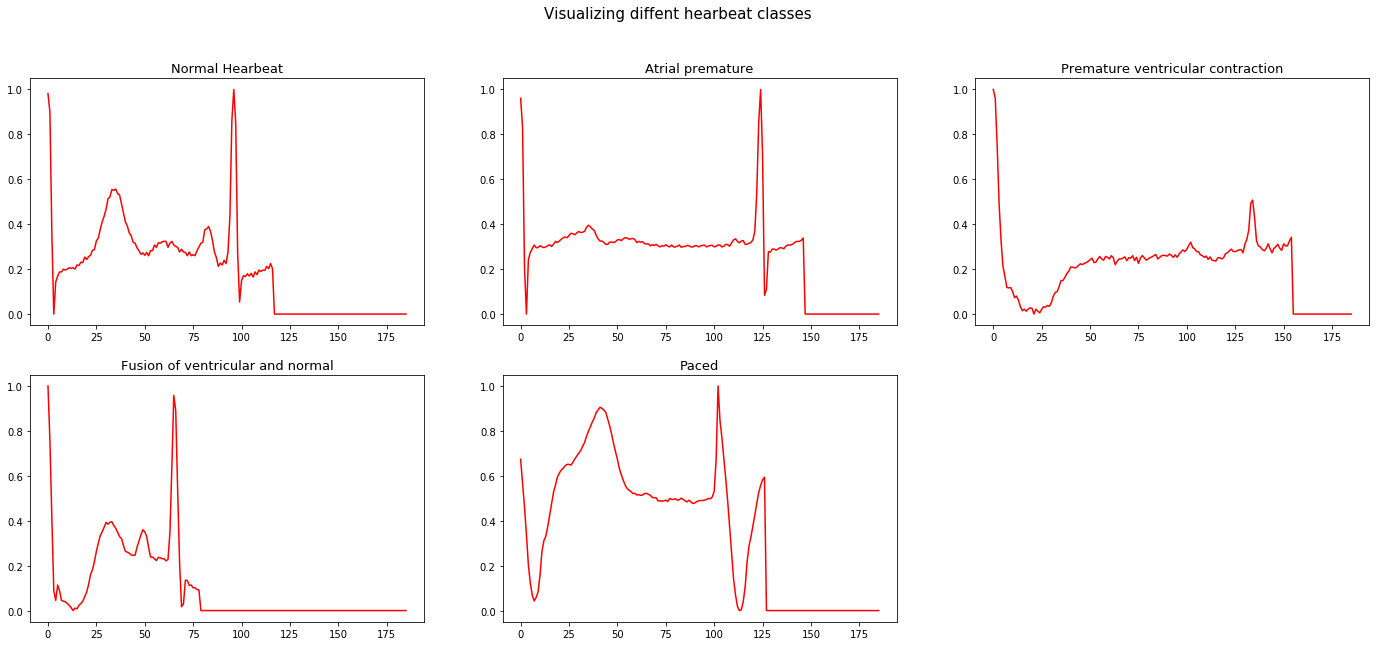

In [34]:
plt.figure(figsize=(24,10))
plt.suptitle("Visualizing diffent hearbeat classes", fontsize=15)

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))


ax1.plot(c.iloc[0,:186])
ax1.set_title("Normal Hearbeat", fontsize=13)
ax2.plot(c.iloc[1,:186])
ax2.set_title("Atrial premature", fontsize=13)
ax3.plot(c.iloc[2,:186])
ax3.set_title("Premature ventricular contraction", fontsize=13)
ax4.plot(c.iloc[3,:186])
ax4.set_title("Fusion of ventricular and normal", fontsize=13)
ax5.plot(c.iloc[4,:186])
ax5.set_title("Paced", fontsize=13)


In [ ]:
def plot_hist(class_number,size,min_,bins):
    img = train_df.loc[train_df[187]==class_number].values
    img = img[:,min_:size]
    img_flatten = img.flatten()

    final1 = np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1 = np.arange(min_,size)
        final1 = np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


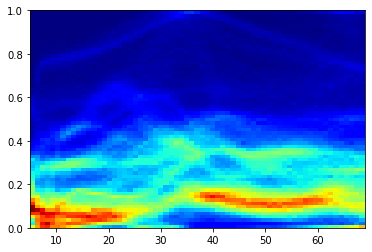

In [ ]:
plot_hist(0,70,5,65)

900000
900000


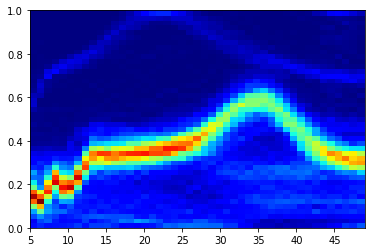

In [ ]:
plot_hist(1,50,5,45)

900000
900000


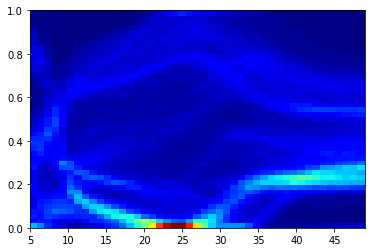

In [ ]:
plot_hist(2,50,5,45)

### **B. Model 1 (Custom CNN)**

In [35]:
def add_gaussian_noise(signal):
    noise = np.random.normal(0,0.5,186)
    return (signal+noise)

In [36]:
target_train = train_df[187]
target_test = test_df[187]
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)

In [37]:
X_train = train_df.iloc[:,:186].values
X_test = test_df.iloc[:,:186].values

print(X_train.shape, " ", X_test.shape)

for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print(X_train.shape, " ", X_test.shape)


(100000, 186)   (21892, 186)
(100000, 186, 1)   (21892, 186, 1)


In [38]:
print(y_train.shape, " ", y_test.shape)

(100000, 5)   (21892, 5)


In [43]:
def network(X_train,y_train,X_test,y_test):
    
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=8),
             ModelCheckpoint(filepath=DATA_PATH + 'best_model.h5', monitor='val_accuracy', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights(DATA_PATH + 'best_model.h5')
    return(model,history)

In [40]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [44]:
model,history = network(X_train, y_train, X_test, y_test)

Epoch 1/40
3125/3125 [==============================] - 110s 34ms/step - loss: 0.9036 - accuracy: 0.6544 - val_loss: 0.9727 - val_accuracy: 0.6633
Epoch 2/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.7964 - accuracy: 0.6969 - val_loss: 0.8525 - val_accuracy: 0.6696
Epoch 3/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.7621 - accuracy: 0.7102 - val_loss: 0.8974 - val_accuracy: 0.6951
Epoch 4/40
3125/3125 [==============================] - 98s 31ms/step - loss: 0.7351 - accuracy: 0.7212 - val_loss: 0.9472 - val_accuracy: 0.6304
Epoch 5/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.7086 - accuracy: 0.7309 - val_loss: 1.0308 - val_accuracy: 0.6075
Epoch 6/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.6836 - accuracy: 0.7416 - val_loss: 0.9751 - val_accuracy: 0.6039
Epoch 7/40
3125/3125 [==============================] - 99s 32ms/step - loss: 0.6577 - accuracy: 0.7513 - val_loss: 1.0162 

Accuracy: 69.51%


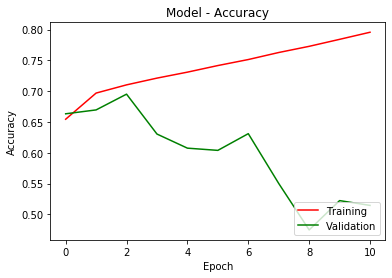

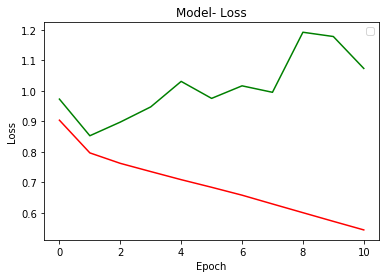

In [45]:
evaluate_model(history, X_test, y_test, model)
y_pred = model.predict(X_test)


### **C. Model 2 (CNN from Paper)**

In [65]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

import math
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns

In [47]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [48]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 186, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 182, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 182, 32)      5152        ['conv1d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 182, 32)      0           ['conv1d_1[0][0]']               
                                                                                              

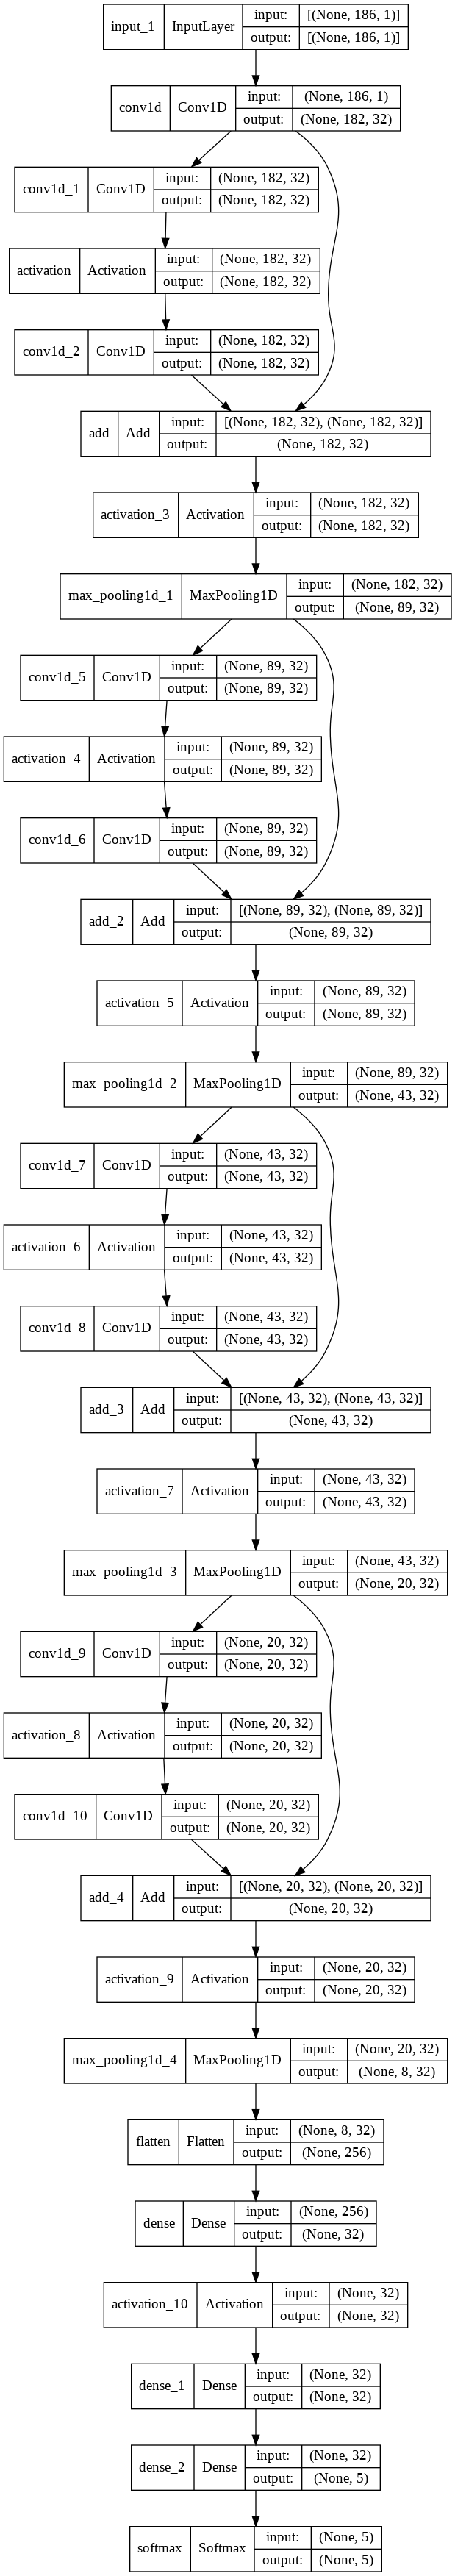

In [61]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=DATA_PATH + 'model_plot.png', show_shapes=True, show_layer_names=True)

In [50]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [51]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [57]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [52]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [58]:
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=batch_size, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lrate, callback])

Epoch 1/75
200/200 [==============================] - 123s 599ms/step - loss: 1.0993 - accuracy: 0.5585 - val_loss: 1.1510 - val_accuracy: 0.4988 - lr: 0.0010
Epoch 2/75
200/200 [==============================] - 94s 470ms/step - loss: 0.9032 - accuracy: 0.6515 - val_loss: 0.9540 - val_accuracy: 0.6121 - lr: 0.0010
Epoch 3/75
200/200 [==============================] - 93s 465ms/step - loss: 0.8493 - accuracy: 0.6753 - val_loss: 0.8115 - val_accuracy: 0.6866 - lr: 0.0010
Epoch 4/75
200/200 [==============================] - 93s 467ms/step - loss: 0.8247 - accuracy: 0.6861 - val_loss: 0.9110 - val_accuracy: 0.6314 - lr: 0.0010
Epoch 5/75
200/200 [==============================] - 91s 453ms/step - loss: 0.8052 - accuracy: 0.6935 - val_loss: 0.7985 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 6/75
200/200 [==============================] - 91s 455ms/step - loss: 0.7901 - accuracy: 0.7000 - val_loss: 0.7553 - val_accuracy: 0.7478 - lr: 0.0010
Epoch 7/75
200/200 [==============================]

In [59]:
model.save(DATA_PATH + 'my_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Internship Files/Velozity/my_model/assets


In [60]:
y_pred = model.predict(X_test, batch_size=1000)

In [106]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [109]:
def evaluate_model(history,X_test,y_test,model):
    
    scores = model.evaluate((X_test),y_test, verbose=0)
    
    fig, axs = plt.subplots(1,3, figsize=(18,5))
    fig.tight_layout()

    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Model - Accuracy')
    axs[0].legend(['Training', 'Validation'], loc='lower right')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Model Loss')
    axs[1].set_title('Model - Loss')
    axs[1].legend(['Training', 'Validation'], loc='upper right')

    target_names=['N','S','V','F','Q']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)    
    g = sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g', ax=axs[2],
                    xticklabels=target_names, yticklabels=target_names)
    plt.show()

    print("\nAccuracy: %.2f%% \n" % (scores[1]*100))
    print(classification_report(y_true, prediction, target_names=target_names))
    

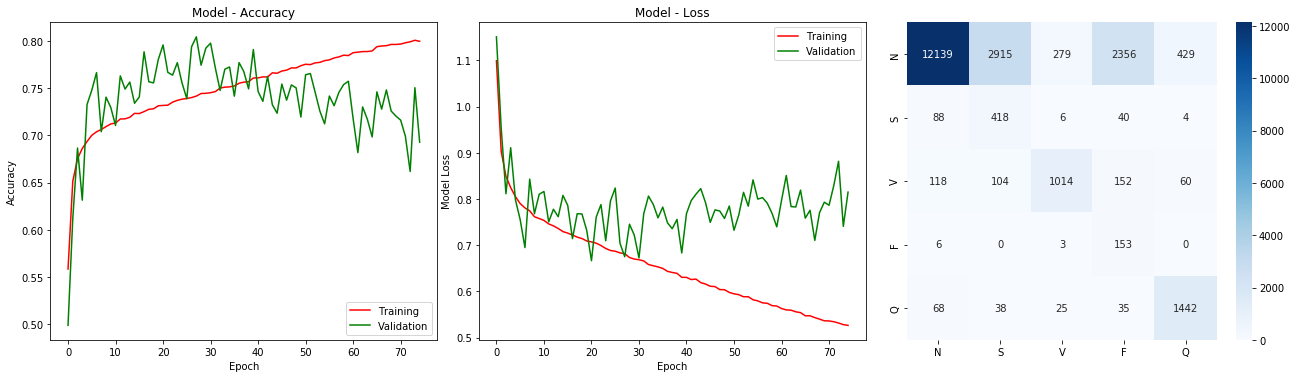

Accuracy: 69.28% 

              precision    recall  f1-score   support

           N       0.98      0.67      0.80     18118
           S       0.12      0.75      0.21       556
           V       0.76      0.70      0.73      1448
           F       0.06      0.94      0.11       162
           Q       0.75      0.90      0.81      1608

    accuracy                           0.69     21892
   macro avg       0.53      0.79      0.53     21892
weighted avg       0.92      0.69      0.77     21892



In [108]:
evaluate_model(history, X_test, y_test, model)

## **4. EDF Processing Test**

In [ ]:
!pip install pyedflib
!pip install tqdm
!pip install wfdb
!pip install biosppy
!pip install datasets
!pip install matplotlib==3.1.3

In [ ]:
import pyedflib

import numpy as np
import matplotlib.pyplot as plt

import os
import wfdb as wf
from scipy import signal
from biosppy.signals import ecg

In [ ]:
f = pyedflib.EdfReader(DATA_PATH + "SampleECG.edf")

In [ ]:
n = f.signals_in_file
signal_labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)

In [ ]:
print(sigbufs)
print(sigbufs.shape)
print(signal_labels)

[[-5.51805170e-03 -6.14612262e-03 -6.86391797e-03 ... -4.48622089e-05
  -4.48622089e-05 -4.48622089e-05]]
(1, 400000)
['ECG']


In [ ]:
plt.figure(figsize=(30,8))
#fig = plt.figure()
ax = plt.axes()
for i in np.arange(n):
  ax.plot(f.readSignal(i))
plt.show()

In [ ]:
print(f.readSignal(0).shape)
print(type(f.readSignal(0)))
print(f.getSampleFrequency(0))

(400000,)
<class 'numpy.ndarray'>
1000.0


In [ ]:
data = sigbufs
print(data,"\n", data.shape)

[[-5.51805170e-03 -6.14612262e-03 -6.86391797e-03 ... -4.48622089e-05
  -4.48622089e-05 -4.48622089e-05]] 
 (1, 400000)


In [ ]:
for channelid, channel in enumerate(data):

        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0

        print("Rpeaks: ", rpeaks)

        beatstoremove = np.array([0])
        beats = np.split(channel, out['rpeaks'])

        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Skip first and last beat.
            if (firstround or lastround):
                continue

            # Get the classification value that is on
            # or near the position of the rpeak index.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Skipping records that are too long.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Pad with zeroes.
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Append the classification to the beat data.
            beats[idx] = np.append(beats[idx], 0)

Rpeaks:  [0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(len(beats), type(beats))
for i in range(10):
  print(len(beats[i]), end=" ")

464 <class 'list'>
250 314 298 326 325 333 298 308 336 339 

In [ ]:
print(len(beatstoremove), type(beatstoremove))
print(beatstoremove.shape)
print(beatstoremove)

463 <class 'numpy.ndarray'>
(463,)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237

In [ ]:
beatstoremove = np.append(beatstoremove, len(beats)-1)

# Remove first and last beats and the ones without classification.
beats = np.delete(beats, beatstoremove)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: ignored

In [ ]:
#savedata = np.array(list(beats[:]), dtype=np.float)
outfn = DATA_PATH + 'SampleECG' +'.csv'
print('Generating ', outfn)
with open(outfn, "wb") as fin:
    np.savetxt(fin, savedata, delimiter=",", fmt='%f')

ValueError: ignored

In [ ]:
import pandas as pd

temp_df = pd.read_csv(DATA_PATH + 'SampleECG.csv', header=None)
temp_df.head()

---

<br>

## **Testing preprocessing**

In [ ]:
!pip install tqdm
!pip install wfdb
!pip install biosppy
!pip install datasets

  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import os
import wfdb as wf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from biosppy.signals import ecg

In [ ]:
record = wf.rdsamp(DATA_PATH + "mit-bih-arrhythmia-database-1.0.0/100")
annotation = wf.rdann(DATA_PATH + "mit-bih-arrhythmia-database-1.0.0/100", 'atr')

In [ ]:
print(record)

(array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']})


In [ ]:
print('Total files: ', len(record))
print("0: \n", record[0], "  ", record[0].shape)
print("\n1: \n", record[1])

Total files:  2
0: 
 [[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]    (650000, 2)

1: 
 {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


In [ ]:
realbeats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

In [ ]:
print('Sampling frequency used for this record:', record[1].get('fs'))
print('Shape of loaded data array:', record[0].shape)
print('Number of loaded annotations:', len(annotation.num))

Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2274


In [ ]:
data = record[0].transpose()

In [ ]:
print(data,"\n", data.shape)

[[-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]
 [-0.065 -0.065 -0.065 ... -0.365 -0.335  0.   ]] 
 (2, 650000)


In [ ]:
cat = np.array(annotation.symbol)
rate = np.zeros_like(cat, dtype='float')

In [ ]:
for catid, catval in enumerate(cat):
  if (catval == 'N'):
      rate[catid] = 1.0 # Normal
  elif (catval in realbeats):
      rate[catid] = 2.0 # Abnormal

In [ ]:
print(rate, "\n", np.unique(rate))

[0. 1. 1. ... 1. 1. 1.] 
 [0. 1. 2.]


In [ ]:
rates = np.zeros_like(data[0], dtype='float')
rates[annotation.sample] = rate

In [ ]:
indices = np.arange(data[0].size, dtype='int')

In [ ]:
for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        print('    ECG channel type:', chname)

        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0

        beatstoremove = np.array([0])
        beats = np.split(channel, out['rpeaks'])

        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Skip first and last beat.
            if (firstround or lastround):
                continue

            # Get the classification value that is on
            # or near the position of the rpeak index.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10
            catval = rates[fromidx:toidx].max()
            
            # Skip beat if there is no classification.
            if (catval == 0.0):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Normal beat is now classified as 0.0 and abnormal is 1.0.
            catval = catval - 1.0

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Skipping records that are too long.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Pad with zeroes.
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Append the classification to the beat data.
            beats[idx] = np.append(beats[idx], catval)

    ECG channel type: MLII
    ECG channel type: V5


In [ ]:
print(len(beats))
for i in range(10):
  print(len(beats[i]), end=" ")

2270
74 188 188 188 188 188 188 188 188 188 

In [ ]:
beatstoremove = np.append(beatstoremove, len(beats)-1)

# Remove first and last beats and the ones without classification.
beats = np.delete(beats, beatstoremove)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
savedata = np.array(list(beats[:]), dtype=np.float)
outfn = DATA_PATH + chname +'.csv'
print('Generating ', outfn)
with open(outfn, "wb") as fin:
    np.savetxt(fin, savedata, delimiter=",", fmt='%f')

Generating  /content/drive/My Drive/Internship Files/Velozity/V5.csv


In [ ]:
import pandas as pd

temp_df = pd.read_csv(DATA_PATH + 'V5.csv', header=None)
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.752733,0.730747,0.159375,0.319714,0.266970,0.307124,0.270779,0.285674,0.281439,0.283470,0.266059,0.277535,0.280732,0.282037,0.273571,0.272187,0.267126,0.282263,0.262759,0.272487,0.264431,0.258931,0.249464,0.261821,0.254205,0.262991,0.234557,0.256163,0.211733,0.225056,0.197015,0.194620,0.162682,0.170036,0.142870,0.155596,0.133188,0.154629,0.165393,0.205240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.628595,0.571475,-0.009939,0.076968,0.122889,0.170717,0.142956,0.171063,0.157647,0.162291,0.163033,0.165251,0.156195,0.173852,0.162099,0.174743,0.167370,0.172260,0.162814,0.178717,0.160566,0.170482,0.157549,0.166379,0.149927,0.163861,0.129142,0.147496,0.112918,0.119430,0.083183,0.095984,0.054228,0.077860,0.043040,0.059578,0.050576,0.093480,0.097575,0.162378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.735441,0.738430,0.084738,0.206169,0.121107,0.179561,0.122728,0.175328,0.116942,0.162638,0.113821,0.158204,0.110882,0.164529,0.117946,0.159603,0.125687,0.151115,0.119840,0.146836,0.117802,0.139753,0.106823,0.125403,0.105927,0.107156,0.082527,0.071278,0.051213,0.047551,0.031255,0.016727,0.018052,0.006963,0.016562,0.029653,0.068658,0.104682,0.144912,0.166005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.738411,0.699388,0.051565,0.203068,0.125145,0.175656,0.134468,0.155478,0.135086,0.151918,0.130952,0.147953,0.130422,0.151835,0.135284,0.153212,0.132960,0.152491,0.123780,0.144768,0.132993,0.149689,0.125274,0.142997,0.113791,0.118125,0.093140,0.094810,0.063433,0.068685,0.016822,0.045053,0.006327,0.042213,0.026445,0.088469,0.094124,0.154359,0.149767,0.192996,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.680462,0.680163,-0.019243,0.161988,0.107638,0.159469,0.108530,0.181673,0.105343,0.170670,0.122808,0.162025,0.126172,0.160585,0.134910,0.170461,0.153536,0.153279,0.133147,0.134548,0.133930,0.149337,0.123503,0.132191,0.136110,0.124082,0.117762,0.088232,0.077982,0.050404,0.034911,0.029181,0.011273,0.007717,0.019675,0.035083,0.044768,0.059371,0.083085,0.134263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
